In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from pandas.tseries.offsets import DateOffset

--- 1. Loading and Exploring Data ---
Missing values in each column:
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64
---------------------------------
Missing values handled using forward fill.
---------------------------------
Starting Exploratory Data Analysis (EDA)...
---------------------------------


/var/folders/0r/rzm5lkxs6r763lxm3q26yh7h0000gn/T/ipykernel_58912/2821499410.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


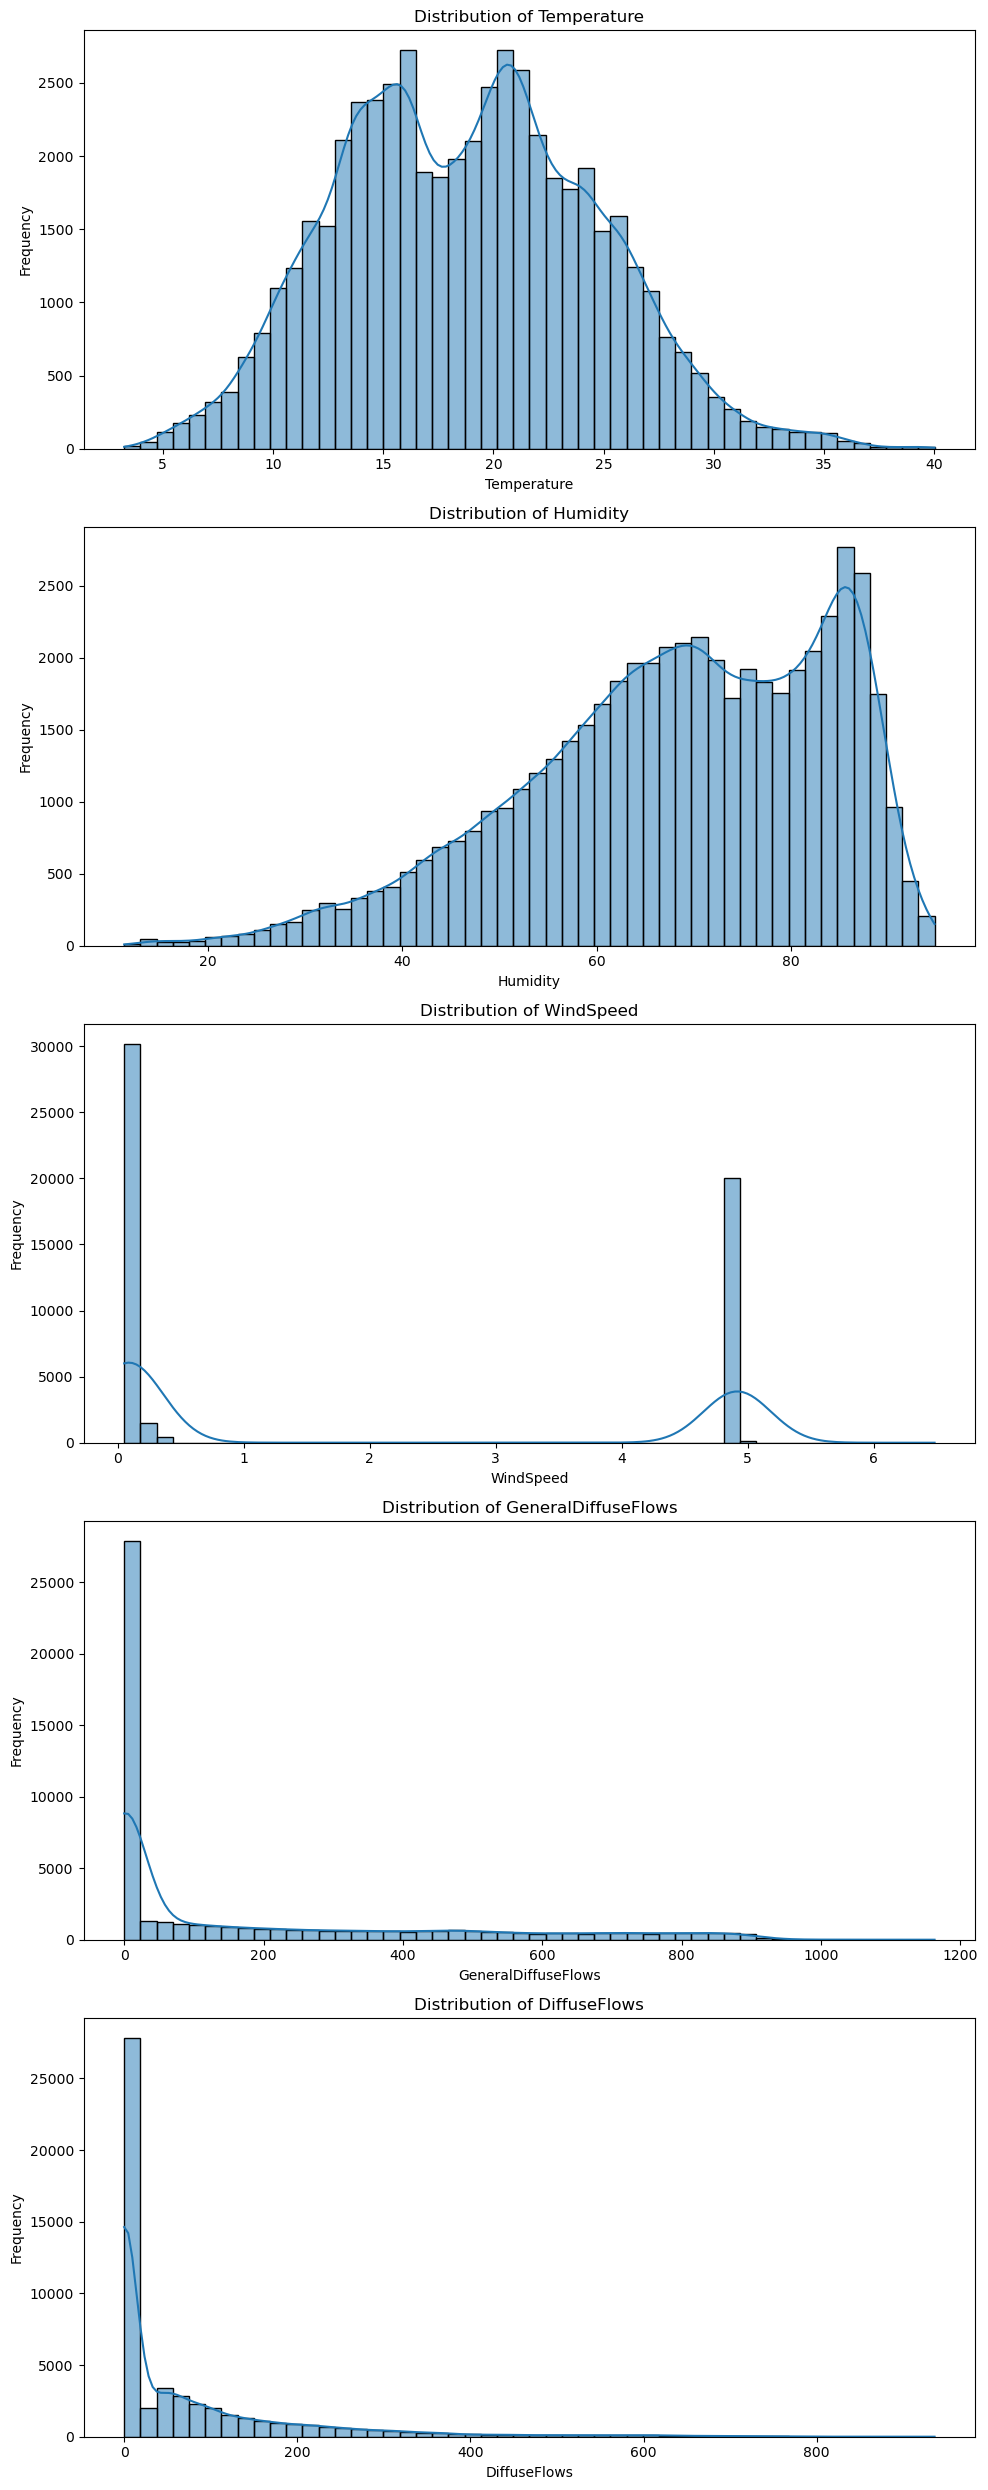

Generating a correlation heatmap...


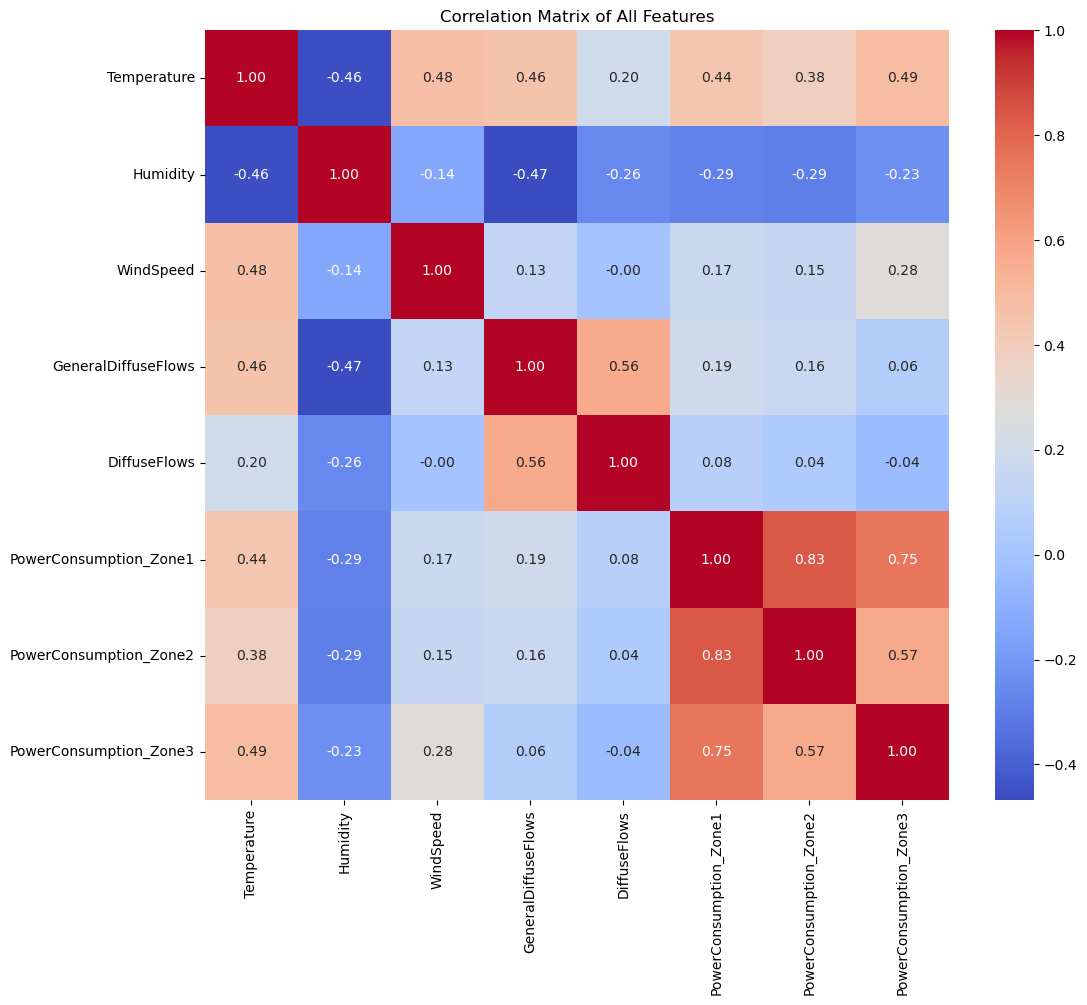

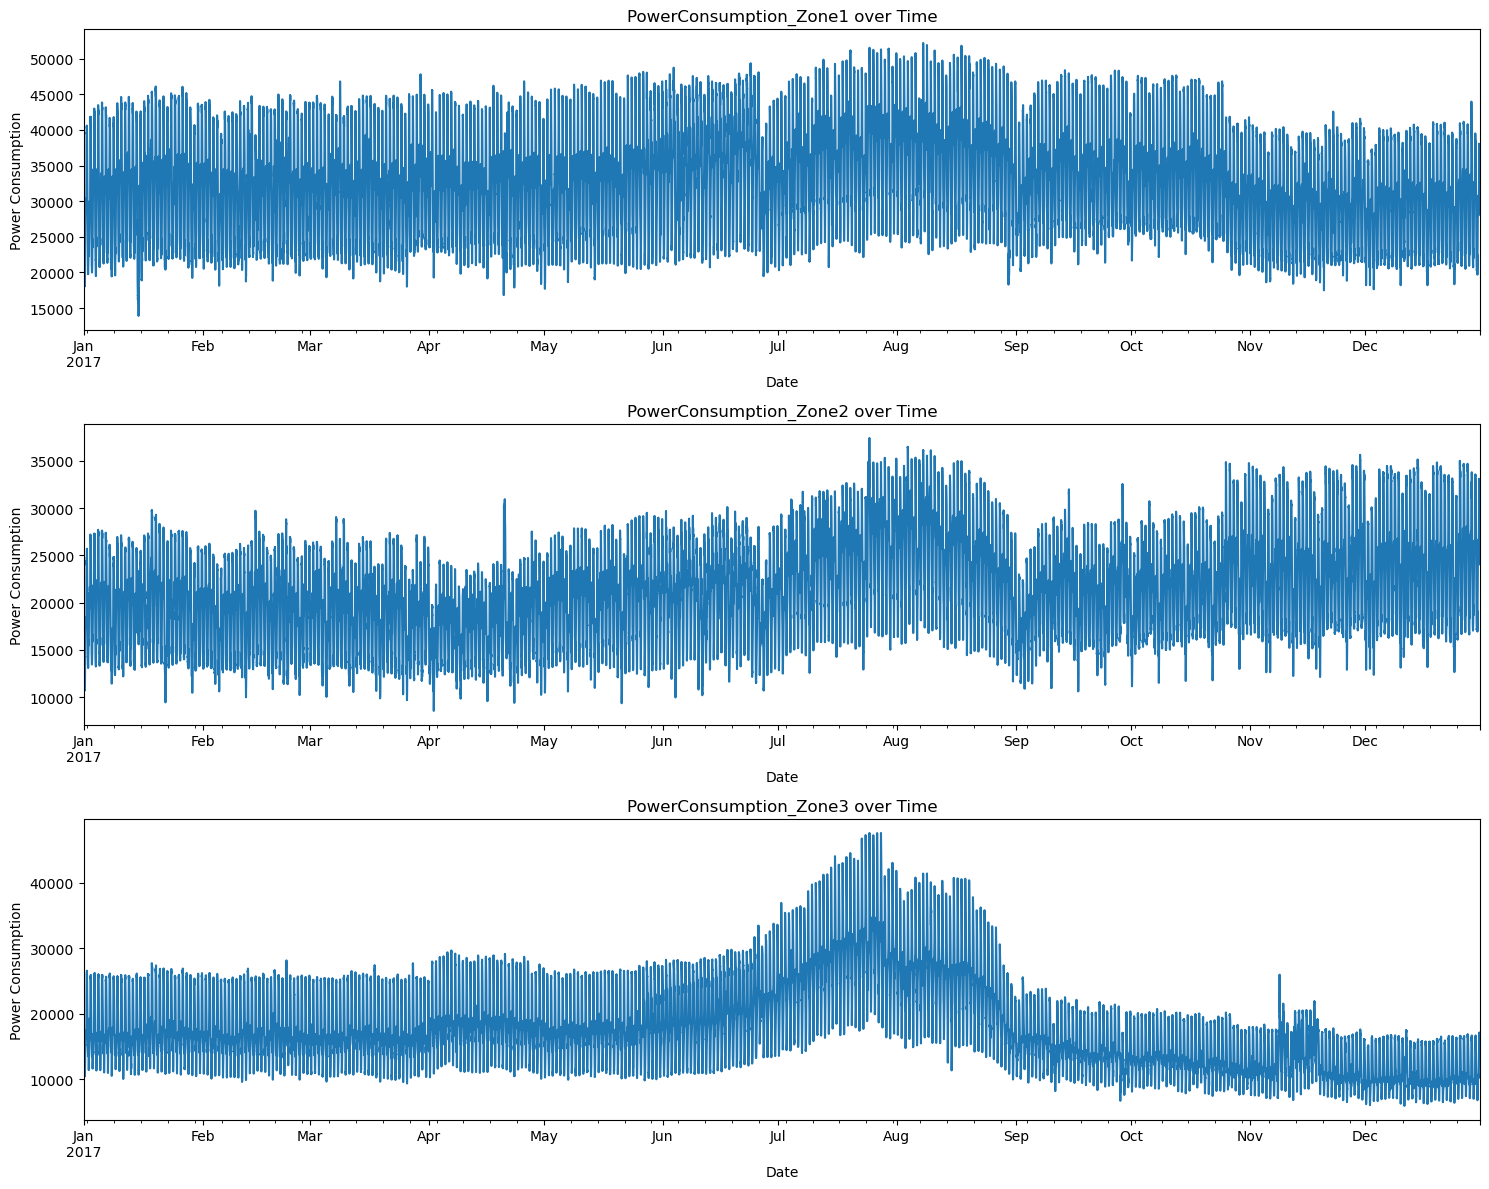

EDA and correlation analysis are complete.
The graphs have been saved to 'distribution_plots.png', 'correlation_heatmap.png', and 'power_consumption_time_series_plots.png'.


In [15]:
#Data Loading and Initial Exploration 
print("---Loading and Exploring Data ---")

# Ensure the 'powerconsumption.csv' file is in the same directory as this script.
file_path = '/Users/yangfeng/Desktop/bootcamp/Lab 10/mini project 3/powerconsumption.csv'
df = pd.read_csv(file_path)

# Convert 'Datetime' column to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Set the 'Datetime' column as the index for time-series analysis
df.set_index('Datetime', inplace=True)

#Handle missing values
# Check for any missing values across all columns.
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)
print("---------------------------------")

# If there were missing values, a simple forward fill is one approach.
df.fillna(method='ffill', inplace=True)
print("Missing values handled using forward fill.")
print("---------------------------------")

#Exploratory Data Analysis (EDA)
print("Starting Exploratory Data Analysis (EDA)...")
print("---------------------------------")

# --- User Advice #1: Distribution plots for key features ---
features_to_plot = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(10, 5 * len(features_to_plot)))

for i, feature in enumerate(features_to_plot):
    sns.histplot(df[feature], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('distribution_plots.png') # Save the plot
plt.show()

#Correlation analysis and heatmap
print("Generating a correlation heatmap...")
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features')
plt.savefig('correlation_heatmap.png') # Save the plot
plt.show()


#Time series plots for Power Consumption in each zone
zones = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
fig, axes = plt.subplots(len(zones), 1, figsize=(15, 12))

for i, zone in enumerate(zones):
    df[zone].plot(ax=axes[i])
    axes[i].set_title(f'{zone} over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Power Consumption')

plt.tight_layout()
plt.savefig('power_consumption_time_series_plots.png')
plt.show()

print("EDA and correlation analysis are complete.")
print("The graphs have been saved to 'distribution_plots.png', 'correlation_heatmap.png', and 'power_consumption_time_series_plots.png'.")

--- Feature Engineering ---
New time-based, lagged, rolling, interaction, and binary features have been added.
The data is now ready for model training.
--- Checking New Features ---
DataFrame head with new features:
                     Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 11:40:00        11.06     53.52      0.082                430.9   
2017-01-01 11:50:00        12.40     53.26      0.080                437.5   
2017-01-01 12:00:00        13.08     54.36      0.077                450.4   
2017-01-01 12:10:00        14.38     54.42      0.076                470.5   
2017-01-01 12:20:00        15.02     56.46      0.074                480.0   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 11:40:00         37.58             29523.03797   
2017-01-01 11:50:00         43.46             29711.3

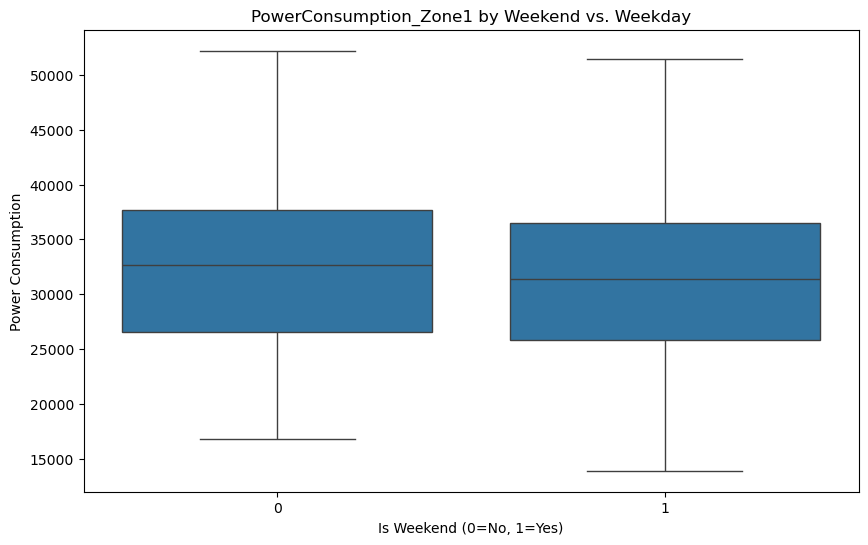

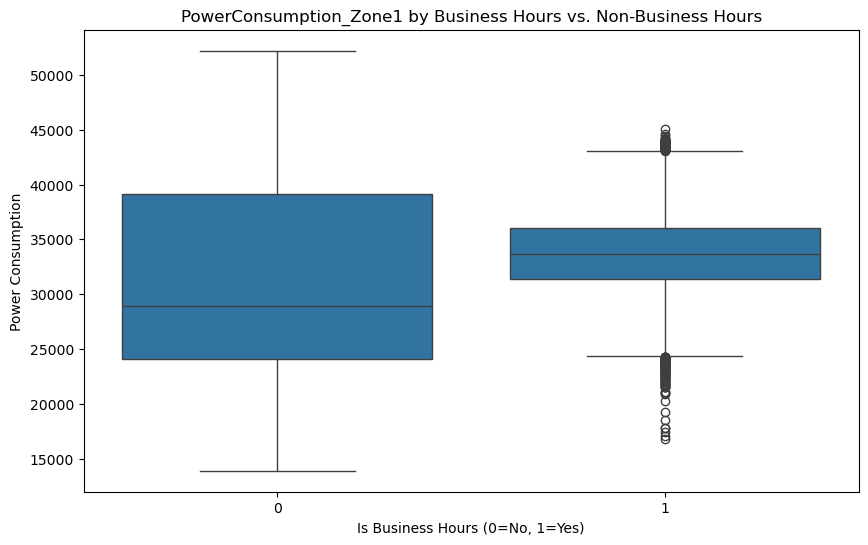

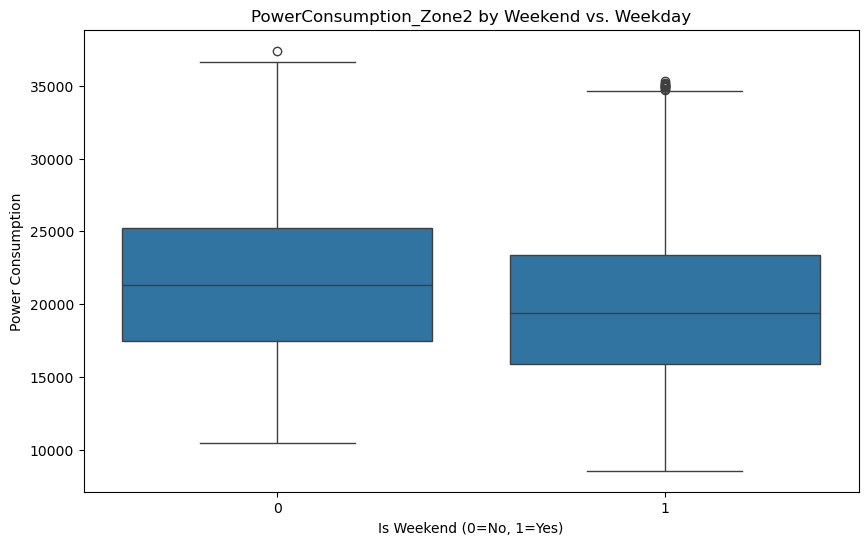

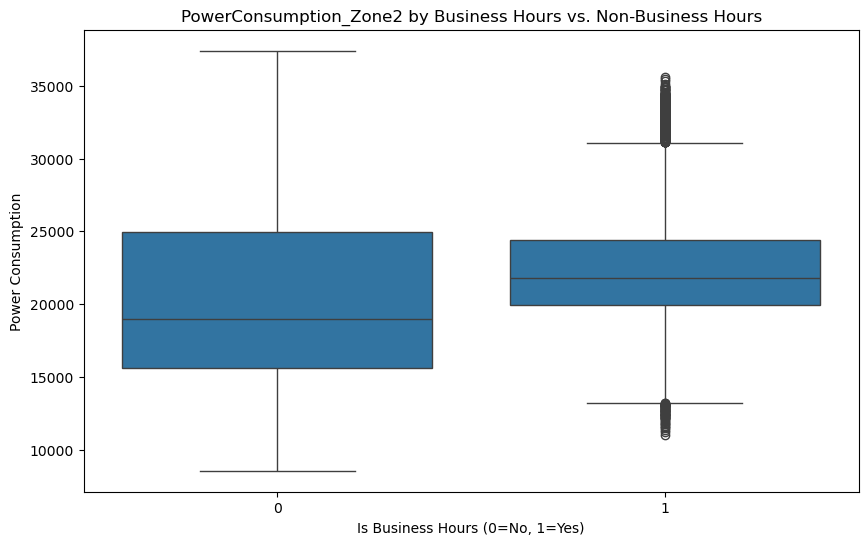

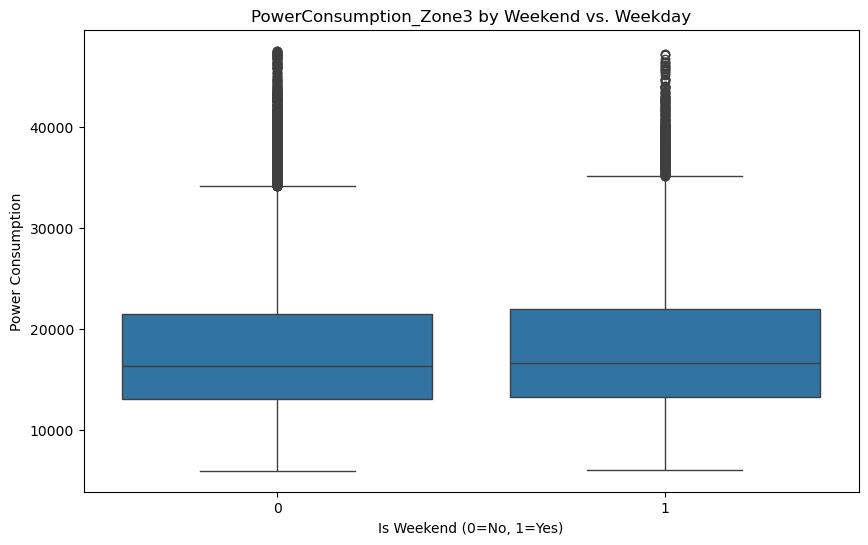

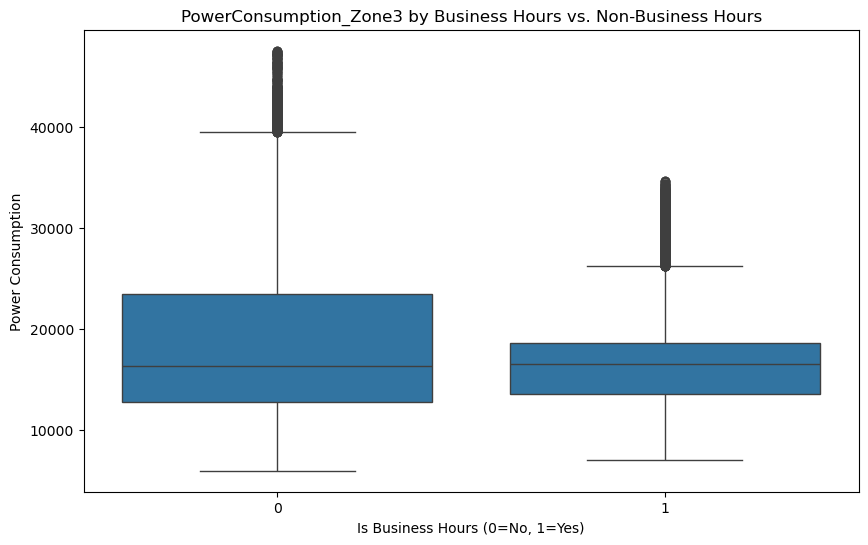

Feature engineering and checks are complete.


In [19]:
#Feature Engineering
print("--- Feature Engineering ---")
# Original time-based features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek'] = df.index.dayofweek
df['weekofyear'] = df.index.isocalendar().week.astype(int)

#Lagged and rolling features
for zone in target_zones:
    df[f'{zone}_lag1'] = df[zone].shift(1)
    df[f'{zone}_rolling_mean'] = df[zone].rolling(window=36).mean()

#Binary features for specific time periods
# Assuming Monday=0 and Sunday=6
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
# Example: Business hours (9 AM to 5 PM)
df['is_business_hours'] = ((df.index.hour >= 9) & (df.index.hour <= 17)).astype(int)

# Drop rows with NaN values that result from shifting/rolling
df.dropna(inplace=True)

print("New time-based, lagged, rolling, interaction, and binary features have been added.")
print("The data is now ready for model training.")

#Check the new features
print("--- Checking New Features ---")

# Display the first few rows to confirm the new columns
print("DataFrame head with new features:")
print(df.head())
print("\n")

# Visualise the impact of the new features
print("Visualizing the impact of binary features...")
for zone in target_zones:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='is_weekend', y=zone, data=df)
    plt.title(f'{zone} by Weekend vs. Weekday')
    plt.xlabel('Is Weekend (0=No, 1=Yes)')
    plt.ylabel('Power Consumption')
    plt.savefig(f'{zone}_weekend_boxplot.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='is_business_hours', y=zone, data=df)
    plt.title(f'{zone} by Business Hours vs. Non-Business Hours')
    plt.xlabel('Is Business Hours (0=No, 1=Yes)')
    plt.ylabel('Power Consumption')
    plt.savefig(f'{zone}_business_hours_boxplot.png')
    plt.show()

print("Feature engineering and checks are complete.")


In [5]:
# Helper function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
# ---Analysis and Modelling for Each Zone ---
all_zone_results = []
for target in zones:
    print(f"--- Running analysis for {target} ---")

    # Define features for scikit-learn models.
    # Updated to include the new binary features.
    features = [
        'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
        'DiffuseFlows', 'year', 'month', 'day', 'hour', 'minute',
        'dayofweek', 'weekofyear',
        f'{target}_lag1', f'{target}_rolling_mean',
        'is_weekend', 'is_business_hours'
    ]

    # Drop any rows with NaN values that resulted from creating lagged features.
    df_cleaned = df.dropna(subset=features)
    
    # Split the data into training and testing sets chronologically
    split_index = int(len(df_cleaned) * 0.8)
    train_df = df_cleaned.iloc[:split_index]
    test_df = df_cleaned.iloc[split_index:]

    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    # --- Machine Learning Models and Forecasting ---
    print("---Machine Learning Models ---")

    # --- Model 1: Linear Regression ---
    print("Training Linear Regression model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)
    print("Done.\n")

    # --- Model 2: Random Forest Regressor ---
    print("Training Random Forest Regressor model...")
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr_model.fit(X_train, y_train)
    rfr_preds = rfr_model.predict(X_test)
    print("Done.\n")

    # --- Model 3: XGBoost Regressor ---
    print("Training XGBoost Regressor model...")
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    print("Done.\n")

    # ---Model Comparison and Evaluation ---
    print("---Model Evaluation and Comparison ---")
    results = []

    # Evaluate Linear Regression
    lr_mae = mean_absolute_error(y_test, lr_preds)
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
    lr_r2 = r2_score(y_test, lr_preds)
    lr_mape = mean_absolute_percentage_error(y_test, lr_preds)
    results.append({'Model': 'Linear Regression', 'MAE': lr_mae, 'RMSE': lr_rmse, 'R2': lr_r2, 'MAPE': lr_mape})

    # Evaluate Random Forest Regressor
    rfr_mae = mean_absolute_error(y_test, rfr_preds)
    rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_preds))
    rfr_r2 = r2_score(y_test, rfr_preds)
    rfr_mape = mean_absolute_percentage_error(y_test, rfr_preds)
    results.append({'Model': 'Random Forest Regressor', 'MAE': rfr_mae, 'RMSE': rfr_rmse, 'R2': rfr_r2, 'MAPE': rfr_mape})

    # Evaluate XGBoost Regressor
    xgb_mae = mean_absolute_error(y_test, xgb_preds)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
    xgb_r2 = r2_score(y_test, xgb_preds)
    xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds)
    results.append({'Model': 'XGBoost Regressor', 'MAE': xgb_mae, 'RMSE': xgb_rmse, 'R2': xgb_r2, 'MAPE': xgb_mape})

    results_df = pd.DataFrame(results)
    results_df['Zone'] = target
    all_zone_results.append(results_df)
    print("Model Performance Comparison:")
    print(results_df)
    print("\n")

--- Running analysis for PowerConsumption_Zone1 ---
--- 5. Machine Learning Models ---
Training Linear Regression model...
Done.

Training Random Forest Regressor model...
Done.

Training XGBoost Regressor model...
Done.

--- 6. Model Evaluation and Comparison ---
Model Performance Comparison:
                     Model         MAE        RMSE        R2      MAPE  \
0        Linear Regression  295.215926  484.611191  0.993829  1.015665   
1  Random Forest Regressor  330.679596  481.555796  0.993907  1.122322   
2        XGBoost Regressor  313.988016  452.886584  0.994611  1.056286   

                     Zone  
0  PowerConsumption_Zone1  
1  PowerConsumption_Zone1  
2  PowerConsumption_Zone1  


--- Running analysis for PowerConsumption_Zone2 ---
--- 5. Machine Learning Models ---
Training Linear Regression model...
Done.

Training Random Forest Regressor model...
Done.

Training XGBoost Regressor model...
Done.

--- 6. Model Evaluation and Comparison ---
Model Performance Comparison:

--- 7. Final Visualization of Predictions ---


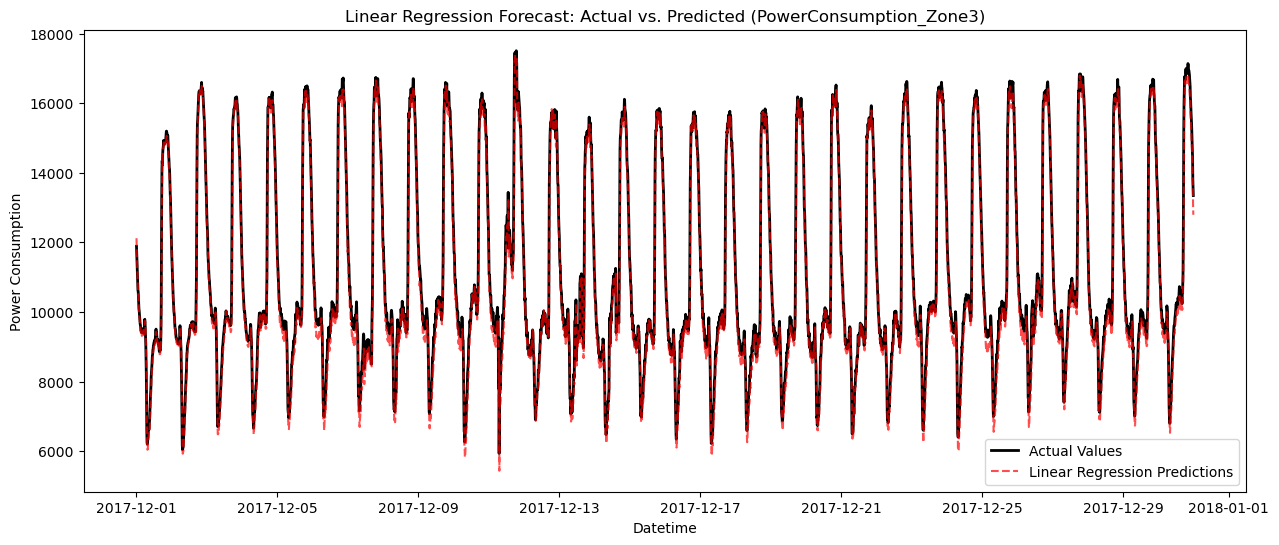

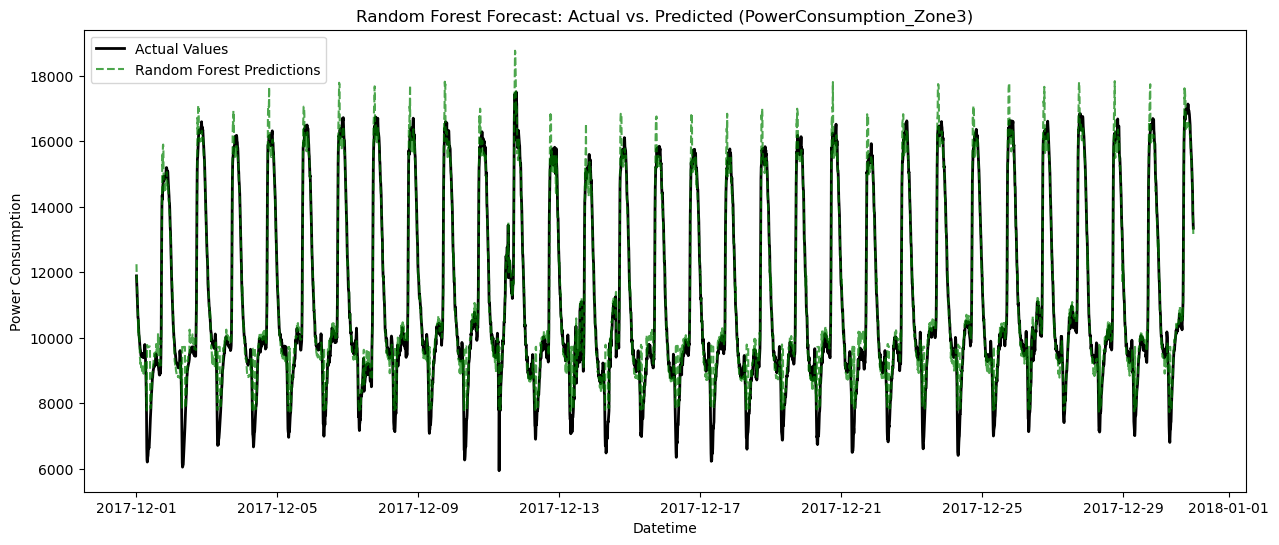

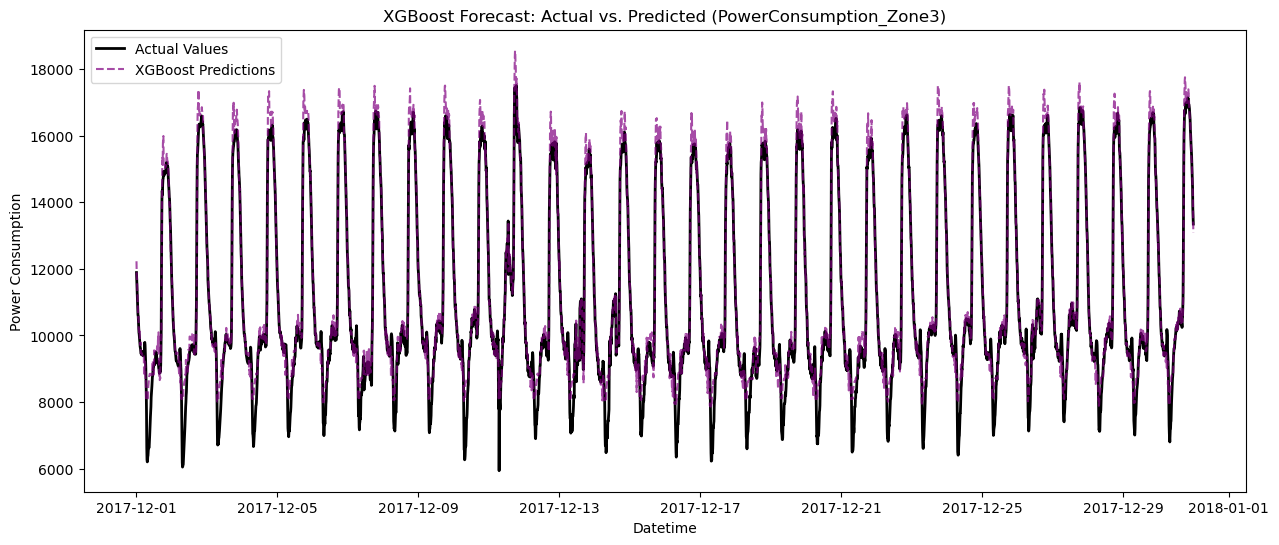

Script finished successfully. All plots and results are now available as separate files for each zone.


In [22]:
# ---Final Visualization of Predictions ---
print("---Final Visualization of Predictions ---")

# Define how many days of the test data to plot for better readability
lookback_period_days = 30 # Plot the last 30 days of the test set
lookback_period_steps = lookback_period_days * 24 * 6
y_test_plot = y_test.iloc[-lookback_period_steps:]

# Plot for Linear Regression
plt.figure(figsize=(15, 6))
plt.plot(y_test_plot.index, y_test_plot, label='Actual Values', color='black', linewidth=2)
plt.plot(y_test_plot.index, lr_preds[-lookback_period_steps:], label='Linear Regression Predictions', color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.title(f'Linear Regression Forecast: Actual vs. Predicted ({target})')
plt.ylabel('Power Consumption')
plt.xlabel('Datetime')
plt.legend()
plt.savefig(f'linear_regression_{target}_forecast.png')
plt.show()

# Plot for Random Forest Regressor
plt.figure(figsize=(15, 6))
plt.plot(y_test_plot.index, y_test_plot, label='Actual Values', color='black', linewidth=2)
plt.plot(y_test_plot.index, rfr_preds[-lookback_period_steps:], label='Random Forest Predictions', color='green', linestyle='--', alpha=0.7, linewidth=1.5)
plt.title(f'Random Forest Forecast: Actual vs. Predicted ({target})')
plt.ylabel('Power Consumption')
plt.xlabel('Datetime')
plt.legend()
plt.savefig(f'random_forest_{target}_forecast.png')
plt.show()

# Plot for XGBoost Regressor
plt.figure(figsize=(15, 6))
plt.plot(y_test_plot.index, y_test_plot, label='Actual Values', color='black', linewidth=2)
plt.plot(y_test_plot.index, xgb_preds[-lookback_period_steps:], label='XGBoost Predictions', color='purple', linestyle='--', alpha=0.7, linewidth=1.5)
plt.title(f'XGBoost Forecast: Actual vs. Predicted ({target})')
plt.ylabel('Power Consumption')
plt.xlabel('Datetime')
plt.legend()
plt.savefig(f'xgboost_{target}_forecast.png')
plt.show()

print("Script finished successfully. All plots and results are now available as separate files for each zone.")

--- 8. Post-Analysis and Model Comparison ---
Final results table for all zones:
                     Model         MAE        RMSE        R2      MAPE  \
0        Linear Regression  295.215926  484.611191  0.993829  1.015665   
1  Random Forest Regressor  330.679596  481.555796  0.993907  1.122322   
2        XGBoost Regressor  313.988016  452.886584  0.994611  1.056286   
3        Linear Regression  289.827321  452.240627  0.993198  1.295546   
4  Random Forest Regressor  259.415953  410.283118  0.994402  1.118694   
5        XGBoost Regressor  232.884713  368.593595  0.995482  0.981646   
6        Linear Regression  241.300605  369.062689  0.987499  2.151539   
7  Random Forest Regressor  332.302512  572.166378  0.969954  3.164386   
8        XGBoost Regressor  307.437294  468.192866  0.979881  2.929848   

                     Zone  
0  PowerConsumption_Zone1  
1  PowerConsumption_Zone1  
2  PowerConsumption_Zone1  
3  PowerConsumption_Zone2  
4  PowerConsumption_Zone2  
5  PowerCo

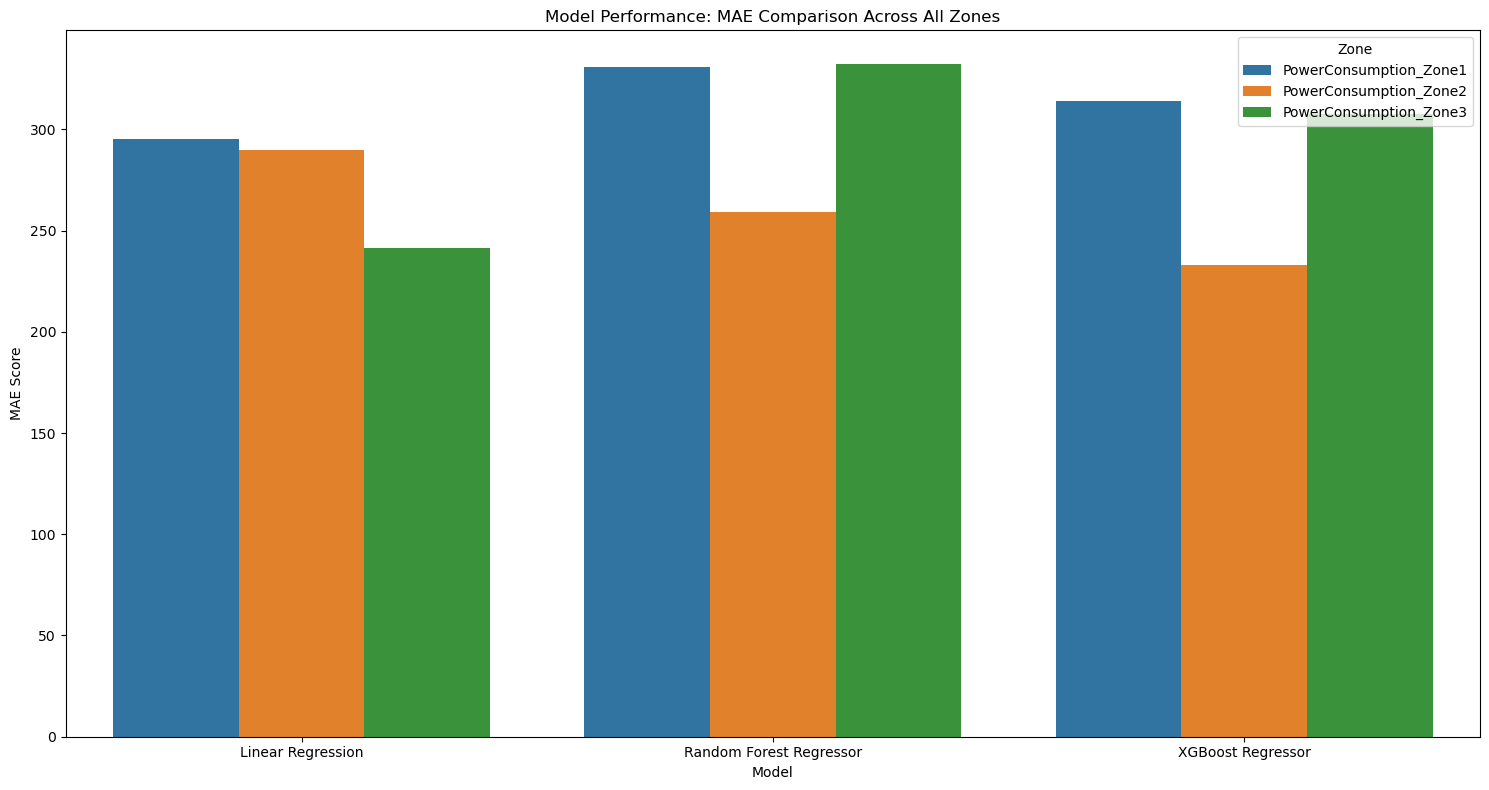

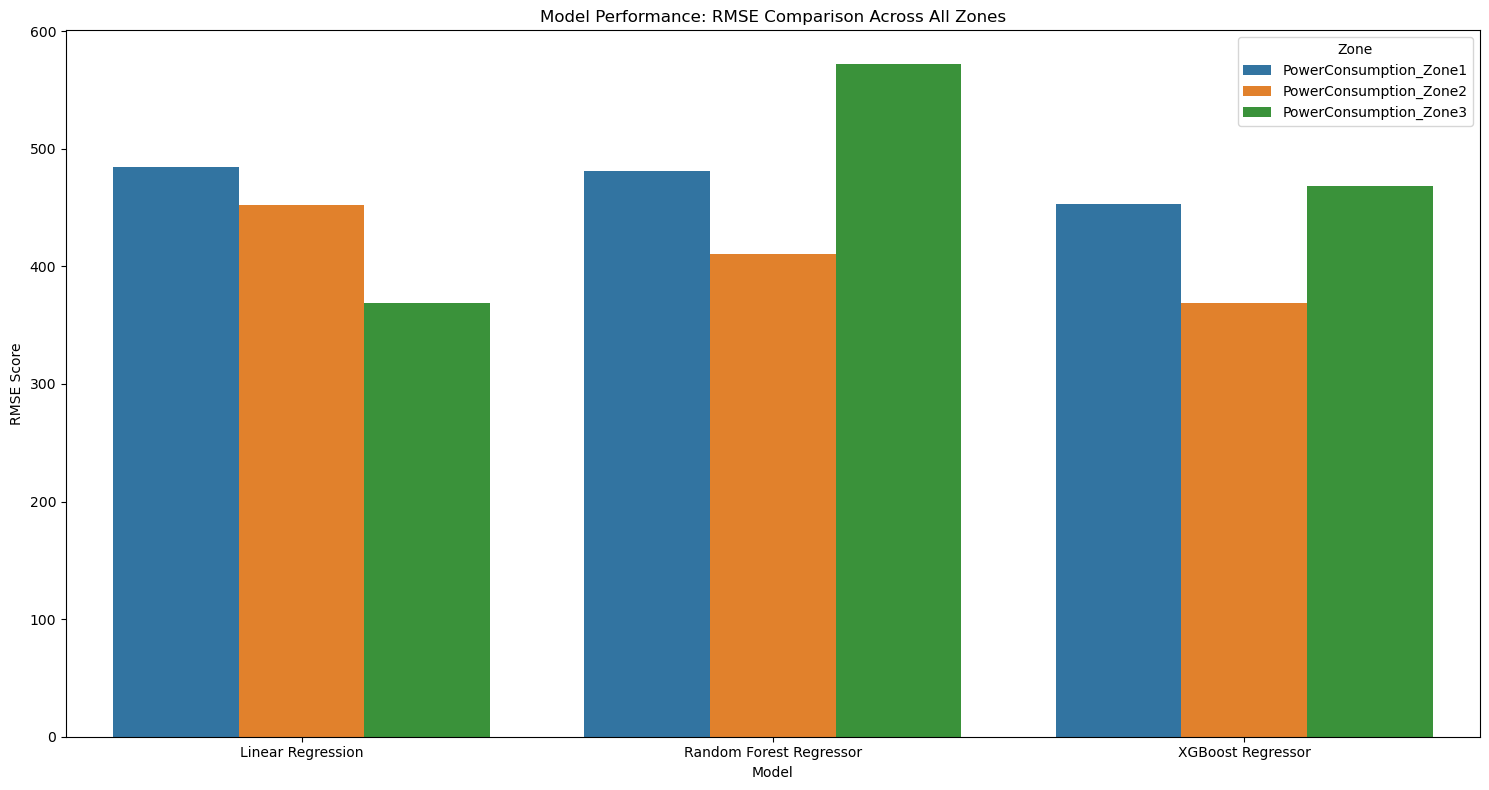

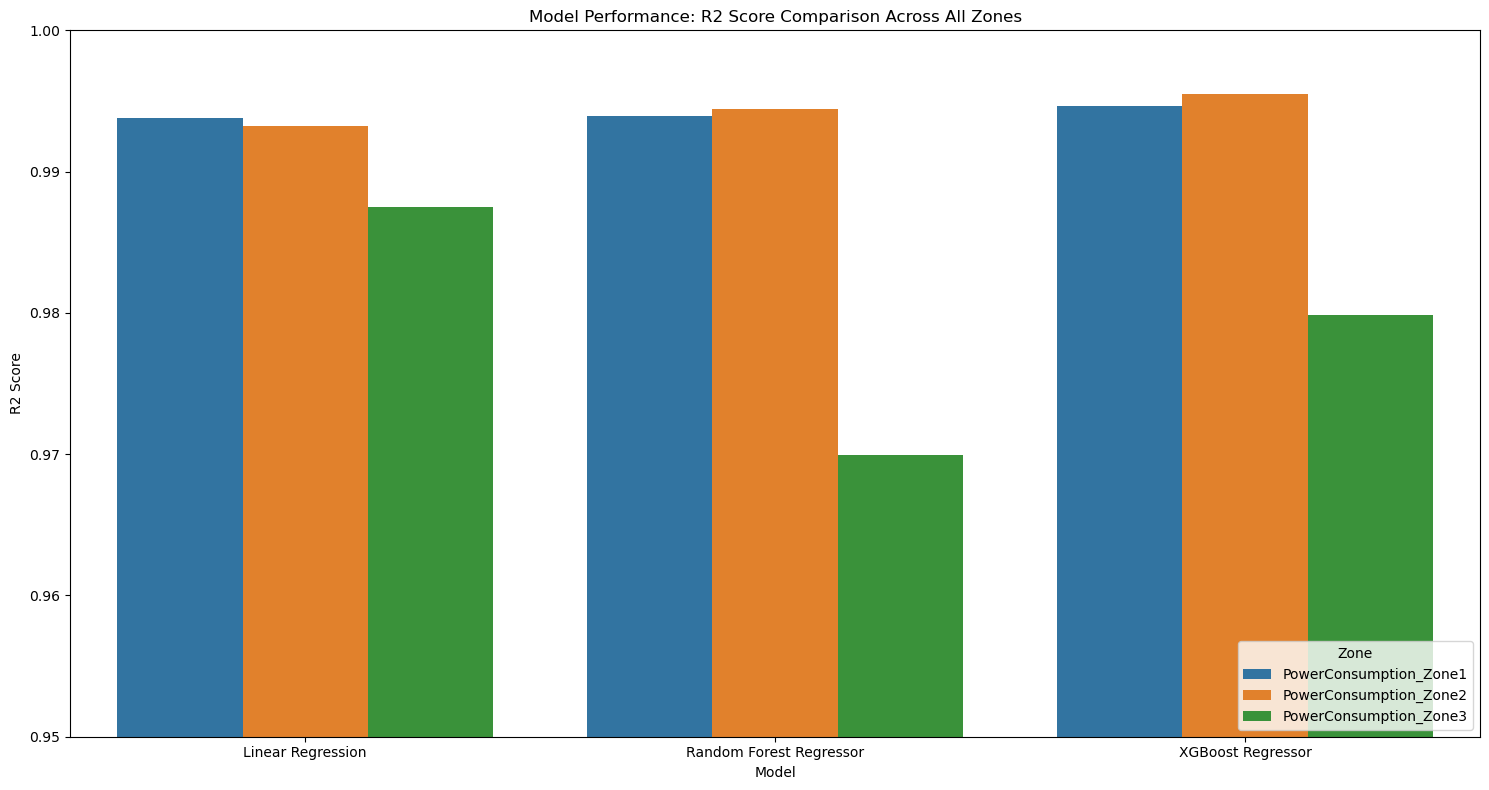

Analyzing model residuals...


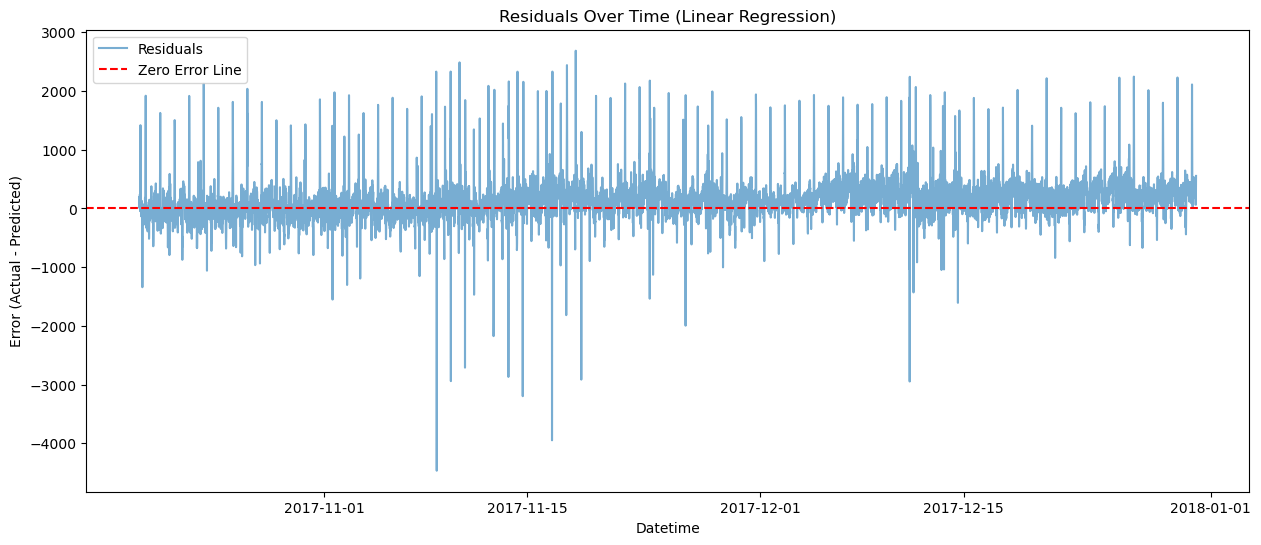

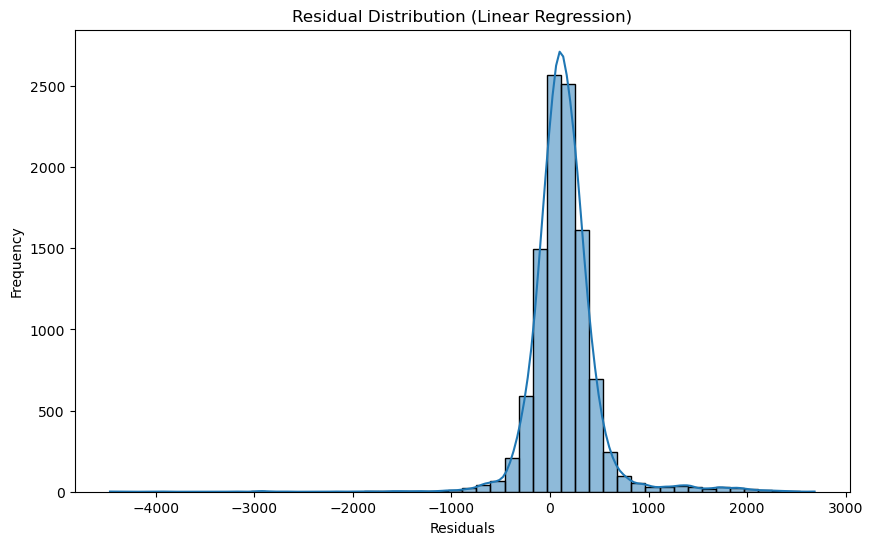

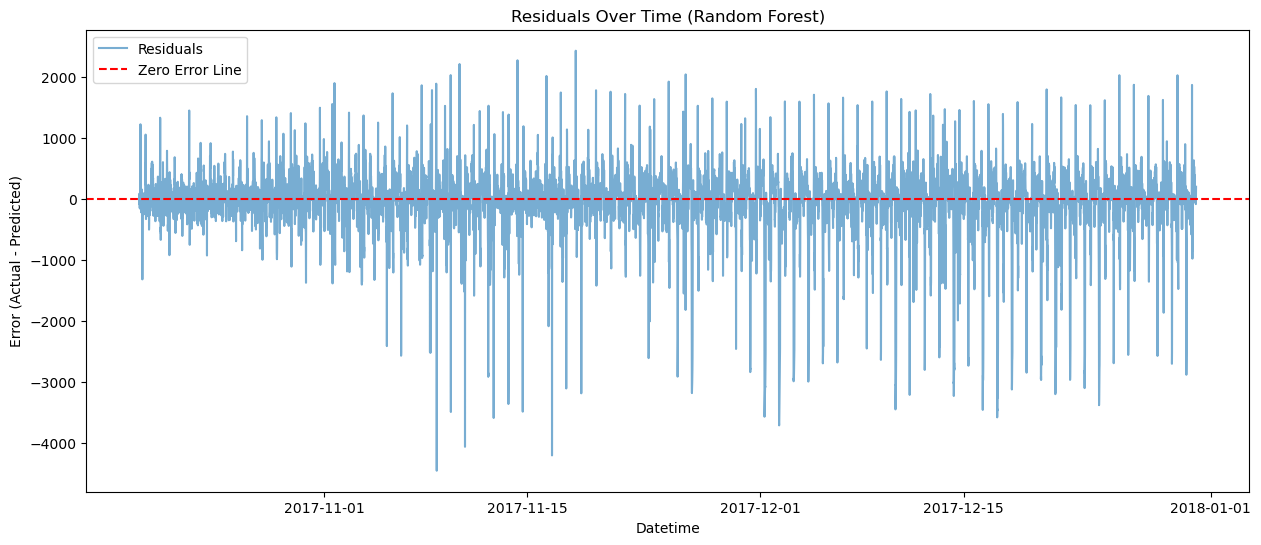

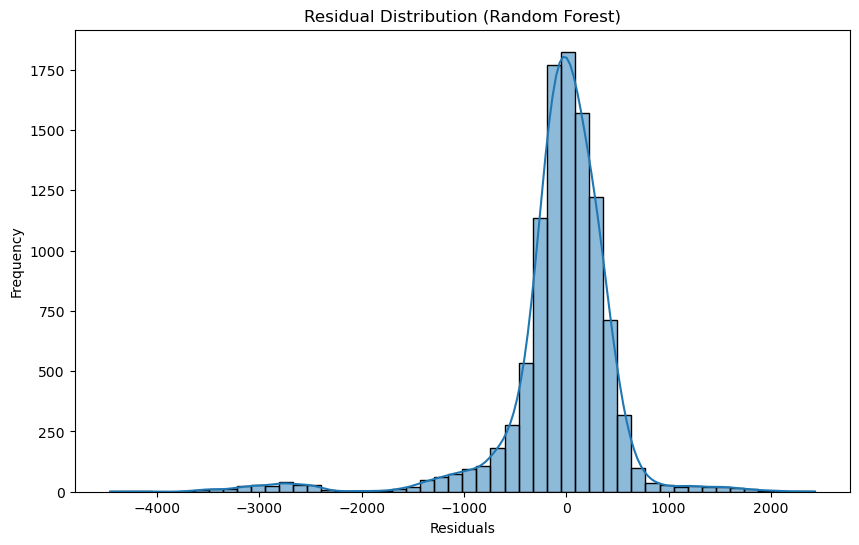

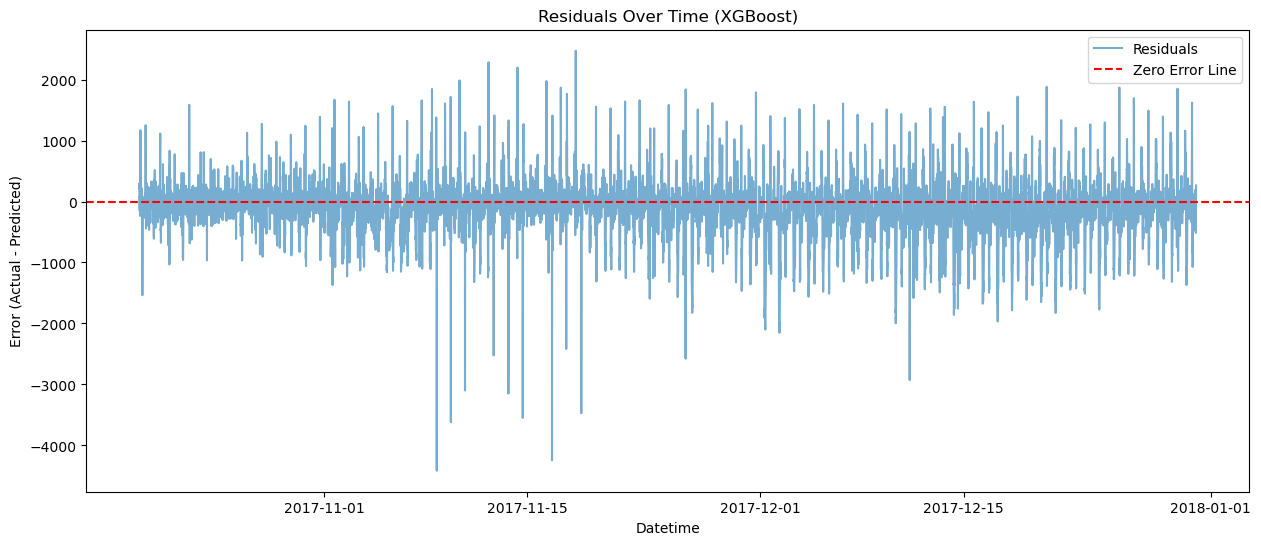

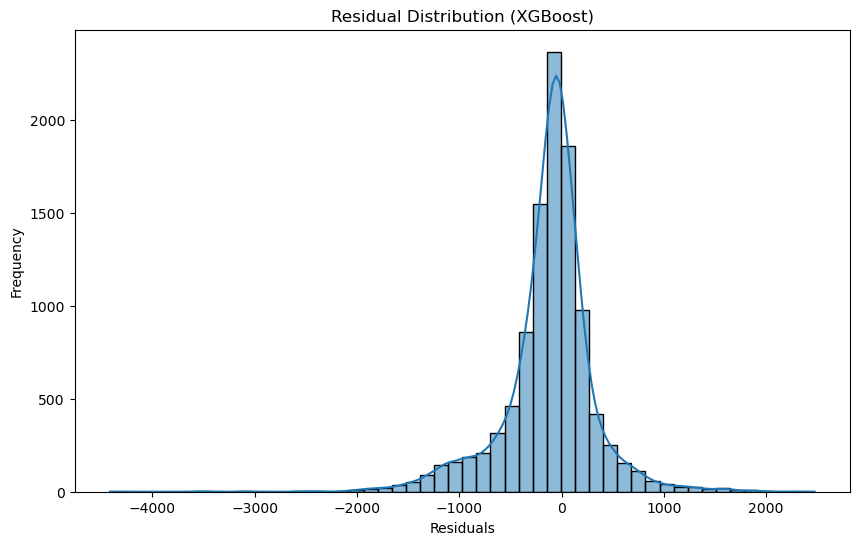

Post-analysis complete. All plots have been saved.


In [34]:
# Define the models and predictions in a dictionary for easy looping
models = {
    'Linear Regression': {'preds': lr_preds, 'model': lr_model},
    'Random Forest': {'preds': rfr_preds, 'model': rfr_model},
    'XGBoost': {'preds': xgb_preds, 'model': xgb_model}
}
# ---Post-Analysis and Model Comparison ---
print("---Post-Analysis and Model Comparison ---")

#Visualise and compare performance metrics
# Concatenate all results into a single DataFrame
final_results_df = pd.concat(all_zone_results, ignore_index=True)
print("Final results table for all zones:")
print(final_results_df)

# --- Consolidated Plotting ---
print("\n--- Consolidated Plotting for all Zones ---")

# Reshape the DataFrame for plotting with Seaborn
mae_rmse_df = pd.melt(final_results_df, id_vars=['Model', 'Zone'], value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Score')

# Plot MAE for all zones in one graph
plt.figure(figsize=(15, 8))
sns.barplot(x='Model', y='MAE', hue='Zone', data=final_results_df)
plt.title('Model Performance: MAE Comparison Across All Zones')
plt.ylabel('MAE Score')
plt.xticks(rotation=0)
plt.legend(title='Zone', loc='upper right')
plt.tight_layout()
plt.savefig('all_zones_mae_comparison.png')
plt.show()

# Plot RMSE for all zones in one graph
plt.figure(figsize=(15, 8))
sns.barplot(x='Model', y='RMSE', hue='Zone', data=final_results_df)
plt.title('Model Performance: RMSE Comparison Across All Zones')
plt.ylabel('RMSE Score')
plt.xticks(rotation=0)
plt.legend(title='Zone', loc='upper right')
plt.tight_layout()
plt.savefig('all_zones_rmse_comparison.png')
plt.show()

# Plot R2 for all zones in one graph
plt.figure(figsize=(15, 8))
sns.barplot(x='Model', y='R2', hue='Zone', data=final_results_df)
plt.title('Model Performance: R2 Score Comparison Across All Zones')
plt.ylabel('R2 Score')
plt.xticks(rotation=0)
plt.ylim(0.95, 1.0)
plt.legend(title='Zone', loc='lower right')
plt.tight_layout()
plt.savefig('all_zones_r2_comparison.png')
plt.show()


#Residual Analysis
print("Analyzing model residuals...")
for name, data in models.items():
    preds = data['preds']
    residuals = y_test - preds

    # Plot residuals over time
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, residuals, alpha=0.6, label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
    plt.title(f'Residuals Over Time ({name})')
    plt.ylabel('Error (Actual - Predicted)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.savefig(f'residuals_over_time_{name}_{target}.png')
    plt.show()

    # Plot a histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=50, kde=True)
    plt.title(f'Residual Distribution ({name})')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.savefig(f'residuals_distribution_{name}_{target}.png')
    plt.show()

print("Post-analysis complete. All plots have been saved.")

--- 8. SARIMA Forecasting for All Zones ---
Training SARIMA model on the last 7 days of data...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11477D+00    |proj g|=  9.00139D-02


 This problem is unconstrained.



At iterate    5    f=  6.09610D+00    |proj g|=  3.55497D-02

At iterate   10    f=  6.09376D+00    |proj g|=  1.41934D-03

At iterate   15    f=  6.09256D+00    |proj g|=  7.50586D-03

At iterate   20    f=  6.06494D+00    |proj g|=  3.65520D-02

At iterate   25    f=  6.05076D+00    |proj g|=  8.80350D-03

At iterate   30    f=  6.05024D+00    |proj g|=  2.67137D-03

At iterate   35    f=  6.05022D+00    |proj g|=  7.50926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     44      1     0     0   3.525D-05   6.050D+00
  F =   6.0502181183038850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/0r/rzm5lkxs6r763lxm3q26yh7h0000gn/T/ipykernel_58912/3320620938.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_index = pd.date_range(start=last_date + pd.Timedelta(minutes=10), periods=forecast_steps, freq='10T')


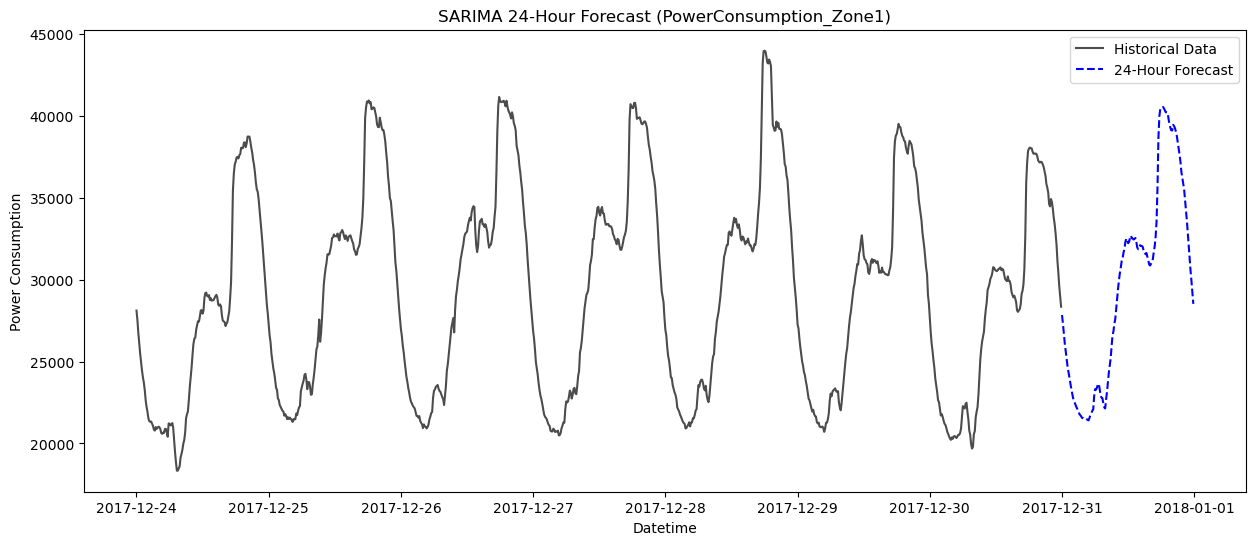

Script finished successfully. Plot saved as 'sarima_short_term_forecast_PowerConsumption_Zone1.png'


In [9]:
# --- SARIMA Forecasting ---
print("---SARIMA Forecasting for All Zones ---")

# Define the number of days of historical data to use for training the model.
# This makes training faster while still capturing recent seasonal patterns.
training_data_days = 7  # 7 days
training_data_steps = training_data_days * 24 * 6

# Define the number of steps for the forecast (24 hours = 144 steps).
forecast_steps = 24 * 6

# Define how many historical steps to show on the plot for context (7 days).
lookback_period_days = 7
lookback_period_steps = lookback_period_days * 24 * 6

# Select the target series
target = 'PowerConsumption_Zone1'

# Select the training data from the last 3 months
train_series = df[target][-training_data_steps:]

# Train the SARIMA model on the smaller subset.
# The seasonal order (P, D, Q, m) captures the daily seasonality (m = 144 steps).
print(f"Training SARIMA model on the last {training_data_days} days of data...")
sarima_model = SARIMAX(
    train_series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 144)  # (P, D, Q, m)
)
sarima_fit = sarima_model.fit()
print("Training complete.\n")

# Forecast the next 24 hours
future_forecast = sarima_fit.forecast(steps=forecast_steps)

# Create a future datetime index for plotting
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(minutes=10), periods=forecast_steps, freq='10T')

# Plot a focused view of the last 7 days of historical data and the future forecast
plt.figure(figsize=(15, 6))

# Slice the historical data to only show the last 7 days
plt.plot(df[target].index[-lookback_period_steps:], df[target][-lookback_period_steps:], label='Historical Data', color='black', alpha=0.7)

# Plot the future forecast
plt.plot(future_index, future_forecast, label='24-Hour Forecast', color='blue', linestyle='--')

plt.title(f'SARIMA 24-Hour Forecast ({target})')
plt.ylabel('Power Consumption')
plt.xlabel('Datetime')
plt.legend()
plt.savefig(f'sarima_short_term_forecast_{target}.png')
plt.show()
print("Script finished successfully. Plot saved as 'sarima_short_term_forecast_PowerConsumption_Zone1.png'")

--- SARIMAX Forecasting for PowerConsumption_Zone1 ---
Training SARIMAX model...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11351D+00    |proj g|=  9.16925D-02

At iterate    5    f=  6.09502D+00    |proj g|=  4.77193D-02

At iterate   10    f=  6.09245D+00    |proj g|=  1.02298D-03

At iterate   15    f=  6.09173D+00    |proj g|=  9.12740D-03

At iterate   20    f=  6.08541D+00    |proj g|=  4.44811D-02

At iterate   25    f=  6.05082D+00    |proj g|=  6.69912D-03

At iterate   30    f=  6.05024D+00    |proj g|=  1.27530D-03

At iterate   35    f=  6.05021D+00    |proj g|=  3.16471D-04

At iterate   40    f=  6.04988D+00    |proj g|=  2.60670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

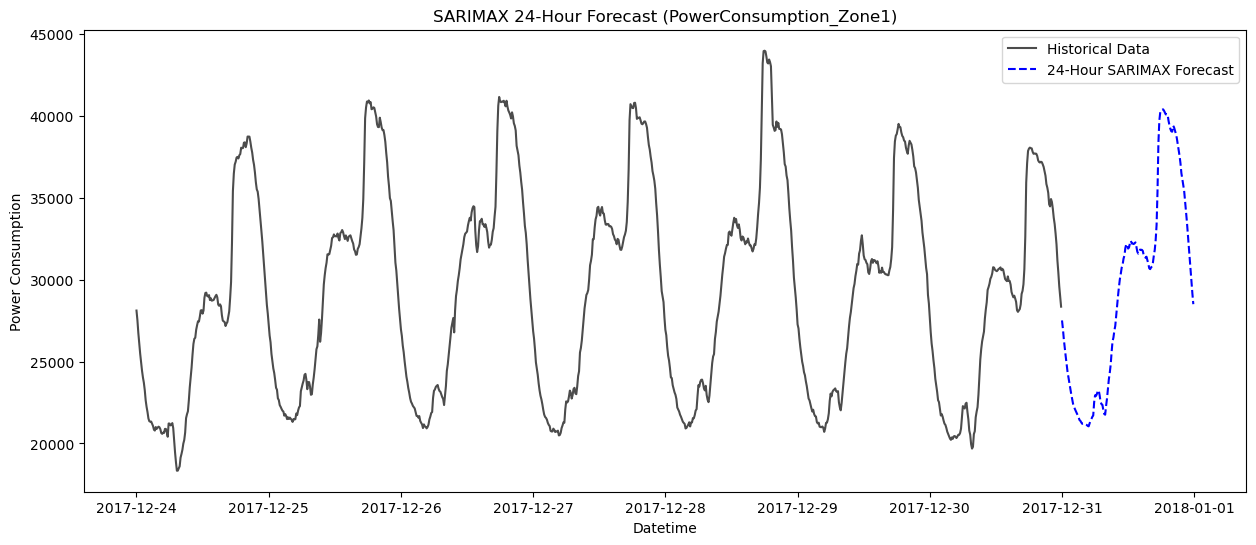

SARIMAX script finished successfully. Plot saved as 'sarimax_future_forecast_PowerConsumption_Zone1.png'


In [28]:
# --- SARIMAX Forecasting for a single zone ---
print("--- SARIMAX Forecasting for PowerConsumption_Zone1 ---")

# Define the target zone and the exogenous variables.
# We will use temperature, humidity, and wind speed as external factors.
target = 'PowerConsumption_Zone1'
exog_features = ['Temperature', 'Humidity', 'WindSpeed']

# Use a recent subset of data for training (e.g., the last 3 months) to speed up the process.
training_data_days = 7
training_data_steps = training_data_days * 24 * 6
train_series = df[target][-training_data_steps:]
train_exog = df[exog_features][-training_data_steps:]

# Define the number of steps for the forecast (24 hours = 144 steps).
forecast_steps = 24 * 6

# --- IMPORTANT: Forecasting with SARIMAX ---
# SARIMAX requires that you provide future values for the exogenous variables.
# For a real-world scenario, you would need a weather forecast for the next 24 hours.
# For this example, we will use the last 24 hours of our dataset as a proxy for the future forecast.
future_exog = df[exog_features][-forecast_steps:]

# Train the SARIMAX model using both the target series and the exogenous variables.
print("Training SARIMAX model...")
sarimax_model = SARIMAX(
    train_series,
    exog=train_exog, # Pass the exogenous training data here
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 144)
)
sarimax_fit = sarimax_model.fit()
print("Training complete.\n")

# Forecast the next 24 hours using the future exogenous data.
future_forecast = sarimax_fit.forecast(steps=forecast_steps, exog=future_exog)

# --- Visualization (same as before) ---
lookback_period_days = 7
lookback_period_steps = lookback_period_days * 24 * 6

plt.figure(figsize=(15, 6))
plt.plot(df[target].index[-lookback_period_steps:], df[target][-lookback_period_steps:], label='Historical Data', color='black', alpha=0.7)
plt.plot(future_forecast.index, future_forecast, label='24-Hour SARIMAX Forecast', color='blue', linestyle='--')
plt.title(f'SARIMAX 24-Hour Forecast ({target})')
plt.ylabel('Power Consumption')
plt.xlabel('Datetime')
plt.legend()
plt.savefig(f'sarimax_future_forecast_{target}.png')
plt.show()

print("SARIMAX script finished successfully. Plot saved as 'sarimax_future_forecast_PowerConsumption_Zone1.png'")